# Open-loop and receding horizon control

In this tutorial we demonstrate how to use CVXPY to solve optimizazion problems. And will compare open-loop control and receding-horizon control.

We have a system with a state $x_k\in {\bf R}^{n_x}$, inputs $u_k\in {\bf R}^{n_u}$, and the following LTI dynamics:

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 0.15 & 0 \\ 0 & 0.85 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  0.1 & 0\\ 0 & 1\end{smallmatrix}\right] u_k.$$

\\

Our goal is to find the optimalcontrol actions $u_0,\ldots,u_{K-1}$ by solving the optimization problem

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} q \, \| x_k\|_2^2 + r \, \| u_k\|_2^2\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{\infty}\leq 3, \quad x_K= 0,
%, \quad \quad k=0, \ldots, K
\end{array}

where $q  = 0.1 $ and $ r = 1$ are constant cost weights on the state and input.

### Convexity
CVXPY can only be used to solve convex optimization problem. Remember an optimization problem is convex if it fulfills the following criteria:
 the costs and constraints are convex.

* The cost function is convex
* The inequallity constraints form a convex set
* The equality constraints are affine

See the Definition on page 136 & 137 in *\[S. Boyd and L. Vandenberghe, 'Convex Optimization', 2004\]*.

**Question 1:**

Is the optimization problem above convex?

**Answer 1:**

Yes

In [8]:
# Generate data for control problem.
import numpy as np


n_x,n_u = 2,2   # state and input dimension

K = 6   # prediction horizon

x_0 = np.array([-6,-3])

# TODO: Complete with dynamic matrices and cost weights

A = np.array([[0.15, 0], [0, 0.85]])
B = np.array([[0.1, 0], [0, 1]])

q = 0.1
r = 1

## Open-loop control
Fill out the blanks below to construct the optization problem above in CVXPY. You can use the different atom functions of CVXPY listed [here](https://www.cvxpy.org/api_reference/cvxpy.atoms.html).

In [14]:
# Form and solve the control problem.
import cvxpy as cp


x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
# Sum problem objectives and concatenate constraints.

for k in range(K):
    cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
    constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
    constr += [cp.norm_inf(u[:,k]) <= 3]

# Add initial and terminal state constraint
constr += [x[:, 0] == x_0]  # Initial condition
constr += [x[:, K] == 0]  # Terminal condition
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()


np.float64(5.904559632010684)

Text(0.5, 1.0, 'Open-loop simulation')

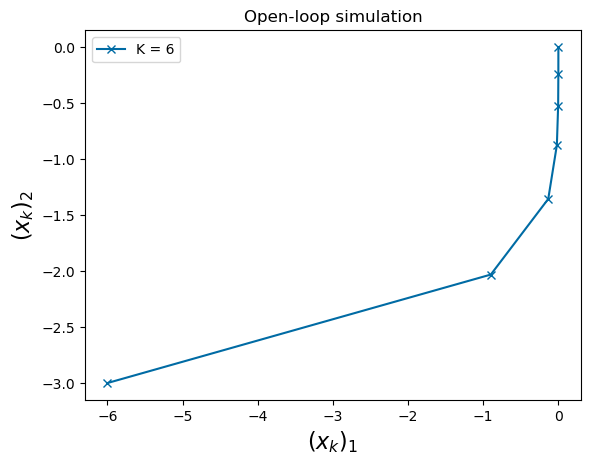

In [15]:
# Plot results.
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

f1 = plt.figure()

plt.plot(x[0,:].value, x[1,:].value, marker = 'x')

plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Open-loop simulation')

# **Question 2:**

Is the terminal state zero?

In [16]:
###  TODO: Print terminal state and check if it is zero
# You can access the value of a variable in cvxpy through the dot notation variable.value

terminal_state = x[:, K].value  # Extract the terminal state value

print("Terminal state:\n", terminal_state)


Terminal state:
 [-1.11225355e-13 -1.43306370e-10]


**TODO:** Solve the same optimization problem again but increase the precision of the solver such that the terminal state is even closer to zero.

In [18]:
### TODO: Solve problem again and print terminal state with higher precision

problem.solve()
np.set_printoptions(precision=10)  # Set NumPy to display more decimal places

terminal_state = x[:, K].value  # Extract the terminal state value

print("Terminal state:\n", terminal_state)



Terminal state:
 [-6.1599816365e-20  1.3779777587e-18]


**Answer 2:**

Even with a zero terminal state constraint, the value will never be exactly zero, but by increasing the precision it gets arbitrarily close to zero. Every solver has a solver precision which can be set in CVXPY. Increasing the precision comes at a higher computational cost especially in large dimensional problems, i.e., the solver requires more iteratios to solve the problem. Depending on the specific application, a more or less precise solution is desirable. In some applications decreasing precision might even be required to reduce computational load, for example in an embedded controller on a small quadrotor such as the crazyfly. Before solving an optimization problem as a control engineer we need to think about the numerical and computational requirements of the machine, plant, device etc. that we want to control.

## Open-loop control: Comparing horizon length

/tmp/ipykernel_159/2195619180.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  ### FILL IN values of K_all


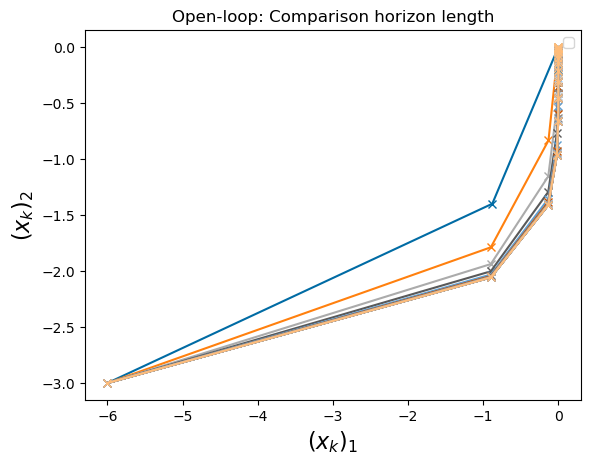

In [24]:
#%% Open loop comparing horizon length

K_all = list(range(2, 21))  # Creates a list of integers from 2 to 20

f2 = plt.figure()


for K in K_all:

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
        constr += [cp.norm_inf(u[:,k]) <= 3]
        
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]  # Initial condition
    constr += [x[:, K] == 0]  # Terminal condition    
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    plt.plot(x[0,:].value, x[1,:].value, marker = 'x' )

plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend()  ### FILL IN values of K_all
plt.title('Open-loop: Comparison horizon length')
plt.show()

**Question 3:**

Why does the state trajectory change with the horizon length? Explain why the state follows the trajectory above for K=10? Why is that cost optimal? You can also inspect the input trajectory using the code below to support your explanation .

**Answer 3:**

Because with longer horizon, the solution gets closer to the infinite horizon solution. In a sense, the system "knows" about cheap opportunities to drive the system to the final state in the future. 

Text(0, 0.5, '$(u_t)_2$')

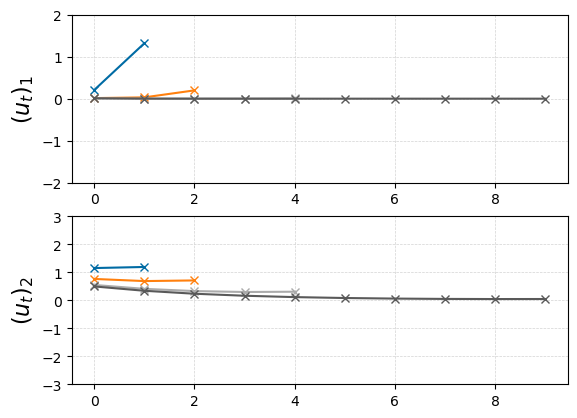

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1)
K_all = [2,3, 5, 10]

for K in K_all:

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
        constr += [cp.norm_inf(u[:,k]) <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]  # Initial condition
    constr += [x[:, K] == 0]  # Terminal condition   
    
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    axs[0].plot(u[0, :].value, marker = 'x')
    axs[1].plot(u[1, :].value, marker = 'x')


axs[0].set_ylim([-2,2])
axs[0].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[0].set_ylabel(r"$(u_t)_1$", fontsize=16)

axs[1].set_ylim([-3,3])
axs[1].grid(which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].set_ylabel(r"$(u_t)_2$", fontsize=16)


## Feasibility
Solve the control problem again for a horizon length of 1.

In [28]:
K = 1
x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
for k in range(K):
    cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
    constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
    constr += [cp.norm_inf(u[:,k]) <= 3]
# sums problem objectives and concatenates constraints.
constr += [x[:, 0] == x_0]  # Initial condition
constr += [x[:, K] == 0]  # Terminal condition   
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

### TODO: Find out on the cvxpy website how to access properties of your solution, like the problem status

# Access and print problem status
print("Problem status:", problem.status)

# Access and print optimal value
print("Optimal value:", problem.value)

# Access and print optimal variable value
print("Optimal variable value:", x.value)

Problem status: infeasible
Optimal value: inf
Optimal variable value: None


**Question 4:**

Why is the ouput of the cvxpy problem infeasible?

**Answer 4**

With the LTI dynamics and the input constraints it is not possible to reach the terminal state zero within one time step. This can also be verified by hand caluclation. Infeasibility of an optimization problem occurs if there is no solution, independent of its cost, that can jointly fulfill all the constraints. In this case here, the combination of dynamic, input and terminal constraints makes the problem infeasible.

# Receding-horizon control

Implement the same control problem above now in a receding-horizon fashion. This encompasses three important steps:

1. Solve open-loop problem for x_0
2. Compute the state evolution by applying the first input of the optimal control sequence $x_{k+1} = A x_{k} + B u_{k} = A x_0 + B u^*_0$, this becomes the new intitial state
3. Save the new state in a state trajectory array.

Repeat $\forall t = 1, \dots, T$.

In [29]:
%%html
<iframe src="https://drive.google.com/file/d/1U3F6pVWZQJ4RRe8Y7CA14EVRr5VLGZLK/preview" width="640" height="220" allow="autoplay"></iframe>

Text(0.5, 1.0, 'Closed-loop simulation')

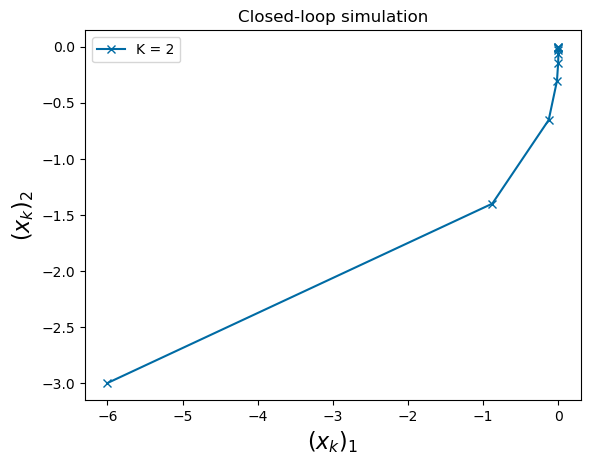

In [33]:
T = 10  # control horizon
K = 2   # prediciton horizon

x_0 = np.array([-6,-3])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    ## FILL IN HERE construct cvxpy problem as above
    cost = 0
    constr = []
    for k in range(K):
        cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
        constr += [cp.norm_inf(u[:,k]) <= 3]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_traj[:, t]]
    constr += [x[:, K] == 0]  # Terminal condition   
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()


    ## FILL IN HERE state evolution
    u_traj[:, t] = u[:, 0].value  # Store applied control
    x_traj[:, t + 1] = A @ x_traj[:, t] + B @ u_traj[:, t]  # State evolution


    ## FILL IN HERE update initial state

f4 = plt.figure()

plt.plot(x_traj[0,:], x_traj[1,:], marker = 'x')

plt.plot()
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Closed-loop simulation')

## Closed-loop $\neq$ Open-loop


In general, in MPC even without noise and disturbances on the state. The closed-loop trajectory will in general not be equal to the predicted open-loop trajectory. Which is illustrated in the Figure below [*Basil Kouvaritakis and Mark Cannon, 'Model Predictive Control' , 2016, page 31*]:


In [34]:
%%html
<iframe src="https://drive.google.com/file/d/1vylq7Fracv4Adl99OJXQBpCIZKZcli7w/preview" width="640" height="480" allow="autoplay"></iframe>

Let's investigate the difference between the open and closed-loop trajectories for different prediciton horizon lengths.

Text(0.5, 1.0, 'Closed-loop simulation')

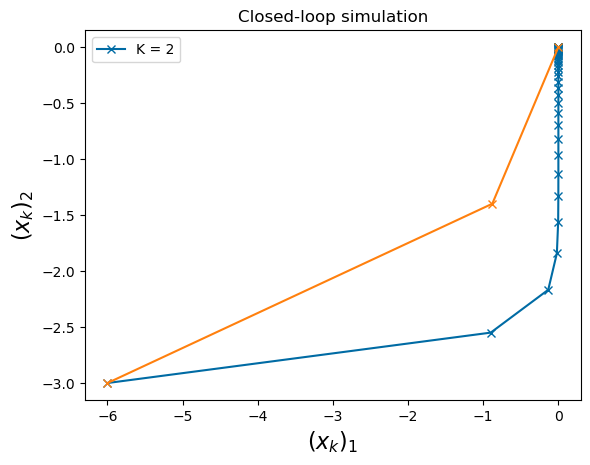

In [44]:
T = 50  # control horizon
K = 2   # prediciton horizon, try K=2,5,10,20 what do you observe?

x_0 = np.array([-6,-3])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=   q * cp.sum_squares(x[:, k]) + r * cp.sum_squares(u[:, k])
        constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k]]  # Dynamics
        constr += [cp.norm_inf(u[:,k]) <= 3]
    constr += [x[:, 0] == x_traj[:, t]]
    constr += [x[:, K] == 0]  # Terminal condition   
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()

    if t == 0:
        x_open = x.value.copy()
        u_open = u.value.copy()

    x_0 = A @ x_traj[:, t] + B @ u_traj[:, t]  # Correct state update

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0


f4 = plt.figure()

plt.plot(x_traj[0,:], x_traj[1,:], marker = 'x')
plt.plot(x_open[0,:], x_open[1,:], marker = 'x')

plt.plot()
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['K = ' + str(K)])
plt.title('Closed-loop simulation')

**Question 5:**

Why does the closed-loop trajectory not match the initial open-loop prediction?

**Answer 5:**

Because after applying the first input, the initial conditions have already changed, leading to a different problem. However, the zero terminal constraint is improving the cost at every state. 

**Question 6:**

What happens if the prediction horizon gets longer and longer? Check this in your simulation. Why does this happen?

**Answer 6:**

The closed loop and open loop trajectories start to match more and more. Both of them become a close approximation to the infinite horizon controller.